# **In-Class Assignment: Feature Engineering, Bag of Words**

## *IS 5150*
## Name: KEY

In this in-class assignment we will explore the more traditional route of textual feature engineering, a family of vector space representation models called *bag of words*. These models ignore sentence structure, word order, and word meaning and instead produce vector representations of words based on their frequencies within and amongst documents.

We will utilize a toy corpus with 'unknown' category labels, and utilize various bag of word models in combination with various unsupervised text mining techniques to try and ascertain appropriate labels for each text in the corpus. 

Let's begin by importing our required libraries and packages:

In [ ]:
import re                                                               # import regex
import nltk                                                             # import nltk

import pandas as pd                                                     # import pandas
import numpy as np                                                      # import numpy
import matplotlib.pyplot as plt                                         # import matplotlib
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer             # import CountVectorizer and TfidfVectorizer from sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity                  # import cosine_similarity from sklearn.metrics.pairwise
from sklearn.decomposition import LatentDirichletAllocation             # import LatentDirichlectAllocation from sklearn.decomposition

from scipy.cluster.hierarchy import fcluster, dendrogram, linkage       # import fcluster, dendrogram, and linkage from scipcy.cluster.hierarchy

pd.options.display.max_colwidth = 200

In [ ]:
nltk.download('stopwords')

## **1) Create a toy corpus**

In [ ]:
corpus = ['The sky is blue 12 and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast, and beans.",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick'
]                                                                                                     # create a toy corpus as a list of 8 sentences

labels = ['topic_?', 'topic_?', 'topic_?', 'topic_?', 'topic_?', 'topic_?', 'topic_?', 'topic_?']     # create list object of 8 mystery labels

> #### **A) Just based on a quick read-over of these texts, how many distinct topics would you propose exist amongst these set of eight sentences?**

> #### **B) Convert corpus and labels to a dataframe**

In [ ]:
corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category':labels})                                     # convert list objects to dataframe
corpus_df

,Document,Category
0,The sky is blue 12 and beautiful.,topic_?
1,Love this blue and beautiful sky!,topic_?
2,The quick brown fox jumps over the lazy dog.,topic_?
3,"A king's breakfast has sausages, ham, bacon, eggs, toast, and beans.",topic_?
4,"I love green eggs, ham, sausages and bacon!",topic_?
5,The brown fox is quick and the blue dog is lazy!,topic_?
6,The sky is very blue and the sky is very beautiful today,topic_?
7,The dog is lazy but the brown fox is quick,topic_?


#### **C) Preprocess text** 

As a final step in developing our corpus, we need to noramlize it. If the goal is to best extract the topic from the text based on the number and variety of words within it, what are the required preprocessing/normalizing steps? Which ones do we not need to implement, based on the given task and texts and why?

*   **Decoding/Removal of HTML**: Not necessary since this isn't webtext
*   **Special Character Removal**: Yes, remove all numbers and non-period punctuation
*   **Case conversion**: Yes, because we don't want to treat upper and lowercase varients of words as unique
*   **Contraction Expansion**: No, there aren't any contractions
*   **Stemming/Lemmatization**: No, sentences are simple and don't contain multiple inflections of words, making this step unneccessary
*   **Stopword Removal**: Yes, we don't need to vectorize stopwords, they don't provide insight into the topic of a text






In [ ]:
wpt = nltk.WordPunctTokenizer()                                                           # assign wordpuncttokenizer to wpt
stop_words = nltk.corpus.stopwords.words('english')                                       # assign stopword to stop_words

def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)                                                 # lowercase and removal special characters, numbers, whitespace
    doc = doc.lower()
    doc = doc.strip()
    tokens = wpt.tokenize(doc)                                                            # tokenize document
    filtered_tokens = [token for token in tokens if token not in stop_words]              # filter out stopwords from document
    doc = ' '.join(filtered_tokens)                                                       # re-join documents from filtered tokens
    return doc

normalize_corpus = np.vectorize(normalize_document)                                       # vectorize normalized documents

In [ ]:
norm_corpus = normalize_corpus(corpus)                                                    # apply normalize_corpus function to corpus
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

## **2) Vector Space Representation Models - Term Frequency**

Now let's apply various means of representing the words and texts as vectors in a higher dimensional space. We begin with the basic bag of words model which utilizes a sparse vector representation based on term-frequency. We will produce word and document vectors within a term-document matrix, using the `CountVectorizer` function from `sklearn`.

In [ ]:
cv = CountVectorizer(min_df = 0., max_df = 1.)                                        # set parameters of Countvectorizer
cv_matrix = cv.fit_transform(norm_corpus)                                             # apply countvectorizer to norm_corpus
print(cv_matrix)                                                                      # view sparse representation

> #### **A) What are we looking at here? What do each of these tuples represent and what is the associated value to right of each tuple?**

The tuple represents the document, and the word (document, word); then the value to right is the number of times the word appears in the document.

> #### **B) Now let's convert `cv_matrix` to an array to view it in a matrix format. What does each row represent? What about each column?**

In [ ]:
cv_matrix = cv_matrix.toarray()                                                 # view in matrix format
cv_matrix 

array([[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]])

Row = document
Column = word

> #### **C) Let's confirm that and also make our matrix easier to read by applying the feature names (vocab names):**

In [ ]:
vocab = cv.get_feature_names_out()                                              # assign feature names to vocab object
tf = pd.DataFrame(cv_matrix, columns=vocab)                                     # convert matrix to DF, column labels from vocab

In [ ]:
tf.shape

(8, 20)

> #### **D) What are the most frequently occurring words in the corpus? Do you think these are the most import words?**

In [ ]:
tf.mean()                                                                                   # compute average of each column to show word frequency (percentage)

bacon        0.250
beans        0.125
beautiful    0.375
blue         0.500
breakfast    0.125
brown        0.375
dog          0.375
eggs         0.250
fox          0.375
green        0.125
ham          0.250
jumps        0.125
kings        0.125
lazy         0.375
love         0.250
quick        0.375
sausages     0.250
sky          0.500
toast        0.125
today        0.125
dtype: float64

#### **E) Bag of N-grams (bi-grams)**

Up to this point, we've been examining the vector representations of words and documents based on unigrams, or individual words. However, oftentimes we wish to create vectors based on a set of co-occurring words in order to gain additional meaning or structure from the text. So, let's re-vectorize our corpus based on all the unique bi-grams (two-word pairs).

**What changes about our term-document matrix?**

In [ ]:
bv = CountVectorizer(ngram_range=(2,2))                                                  # set parameters of countvectorizer to bigrams
bv_matrix = bv.fit_transform(norm_corpus)                                                # apply vectorizer to norm_corpus

bv_matrix = bv_matrix.toarray()                                                          # set matrix object to array
vocab = bv.get_feature_names_out()                                                       # get bi-gram vocab labels
bf = pd.DataFrame(bv_matrix, columns=vocab)                                              # convert array to dataframe, use vocab as column labels

The bi-gram term-document matrix has a greater number of dimensions, 29 vs 20 in the unigram term-document matrix.

> #### **F) Examine the vector of document 0 for the unigram and bigram representation. Which is sparser?**

In [ ]:
bf.loc[0]                                                                               # view first row (index = 0)

bacon eggs            0
beautiful sky         0
beautiful today       0
blue beautiful        1
blue dog              0
blue sky              0
breakfast sausages    0
brown fox             0
dog lazy              0
eggs ham              0
eggs toast            0
fox jumps             0
fox quick             0
green eggs            0
ham bacon             0
ham sausages          0
jumps lazy            0
kings breakfast       0
lazy brown            0
lazy dog              0
love blue             0
love green            0
quick blue            0
quick brown           0
sausages bacon        0
sausages ham          0
sky beautiful         0
sky blue              1
toast beans           0
Name: 0, dtype: int64

In [ ]:
tf.loc[0]                                                                                 # view first row (index = 0)

bacon        0
beans        0
beautiful    1
blue         1
breakfast    0
brown        0
dog          0
eggs         0
fox          0
green        0
ham          0
jumps        0
kings        0
lazy         0
love         0
quick        0
sausages     0
sky          1
toast        0
today        0
Name: 0, dtype: int64

The bigram representation is sparser in this case; given the simplicity of the text, it doesn't seem worth it to add extra complexity (dimensions) to the text representation.

## **3) Weighted Vector Space Representation -- TF-IDF Vectorizer**

As we discussed in 2D, the most important words are not always the most frequent words. Term frequency-inverse document frequency provides a weighting to each word, in an attempt to balance the importance of words based on how frequent they are in specific documents, vs. all documents.

We can easily calculate the tf-idf of each word in our corpus using the `TfidfVectorizer` from `sklearn`.

In [ ]:
tv = TfidfVectorizer(min_df=0., max_df=1., norm = 'l2',
                    use_idf = True, smooth_idf = True)                                          # set parameters of tf-idf vectorizer

tv_matrix = tv.fit_transform(norm_corpus)                                                       # apply tf-idf to norm_corpus
tv_matrix = tv_matrix.toarray()                                                                 # convert to array

vocab = tv.get_feature_names_out()                                                              # apply vocab labels
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)                                             # convert to DF, round to 2 decimal places

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0.00,0.00,0.60,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.0
1,0.00,0.00,0.49,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,0.00,0.00,0.49,0.00,0.0
2,0.00,0.00,0.00,0.00,0.00,0.38,0.38,0.00,0.38,0.00,0.00,0.53,0.00,0.38,0.00,0.38,0.00,0.00,0.00,0.0
3,0.32,0.38,0.00,0.00,0.38,0.00,0.00,0.32,0.00,0.00,0.32,0.00,0.38,0.00,0.00,0.00,0.32,0.00,0.38,0.0
4,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.00,0.47,0.39,0.00,0.00,0.00,0.39,0.00,0.39,0.00,0.00,0.0
5,0.00,0.00,0.00,0.37,0.00,0.42,0.42,0.00,0.42,0.00,0.00,0.00,0.00,0.42,0.00,0.42,0.00,0.00,0.00,0.0
6,0.00,0.00,0.36,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.00,0.5
7,0.00,0.00,0.00,0.00,0.00,0.45,0.45,0.00,0.45,0.00,0.00,0.00,0.00,0.45,0.00,0.45,0.00,0.00,0.00,0.0


> #### **A) Examine the tfidf term-document matrix, what observations can you make about the difference between these vector representations as compared to the term-frequency based representations?**

> #### **B) Document Similarity**

> **Let's utilize our new document vectors to examine document similarity, this might provide some additional insight into the number of categories amongst our topics, and which documents fall into those categories. We can quantify document similarity by examining the distance (via `cosine_similarity`) between document vectors.**

In [ ]:
similarity_matrix = cosine_similarity(tv_matrix)                                      # apply cosine_similarity to tf-idf matrix
similarity_df = pd.DataFrame(similarity_matrix)                                       # display similarity matrix

similarity_df.style.background_gradient(cmap="Blues")                                 # let's make it easier to read

,0,1,2,3,4,5,6,7
0,1.000000,0.820599,0.000000,0.000000,0.000000,0.192353,0.817246,0.000000
1,0.820599,1.000000,0.000000,0.000000,0.225489,0.157845,0.670631,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.791821,0.000000,0.850516
3,0.000000,0.000000,0.000000,1.000000,0.506866,0.000000,0.000000,0.000000
4,0.000000,0.225489,0.000000,0.506866,1.000000,0.000000,0.000000,0.000000
5,0.192353,0.157845,0.791821,0.000000,0.000000,1.000000,0.115488,0.930989
6,0.817246,0.670631,0.000000,0.000000,0.000000,0.115488,1.000000,0.000000
7,0.000000,0.000000,0.850516,0.000000,0.000000,0.930989,0.000000,1.000000


> #### **Which two documents are most similar? Is that surprising?**

> #### **C) Document Clustering with Similarity Features**

> Let's take our analysis a step further now, and use the pairwise document similarities to perform an unsupervised text mining technique, document clustering. This method will evaluate the distance between documents, based on their cosine similarities to find naturally occurring clusters of documents.

> We can produce a nice visualization of these clusters using a Dendrogram!

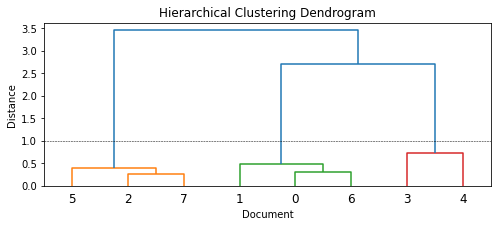

In [ ]:
from matplotlib.pyplot import figure
Z = linkage(similarity_matrix, 'ward')                                                  # use ward-linkage function, apply to similarity_matrix

plt.figure(figsize=(8,3))                                             
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Document')
plt.ylabel('Distance')
dendrogram(Z)                                                                           # plot a dendrogram of Z
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)
plt.show()

> **What can we deduce from this visualization? How does this relate to our results from the similarity matrix?**

> #### **D) Cluster Labeling**

> Now we have good reason to support that there are three distinct clusters, or categories of documents. Let's add our cluster labels to our original corpus dataframe. Next, we'll try to figure out some good labels for our clusters/categories of documents.

In [ ]:
max_dist = 1.0                                                                            # set max distance to 1

cluster_labels = fcluster(Z, max_dist, criterion = 'distance')                            # fit clusters using Z object
cluster_labels = pd.DataFrame(cluster_labels, columns=['Cluster Label'])                  # convert cluster_labels to DF 
pd.concat([corpus_df, cluster_labels], axis = 1)                                          # append cluster labels to corpus DF

,Document,Category,Cluster Label
0,The sky is blue 12 and beautiful.,topic_?,2
1,Love this blue and beautiful sky!,topic_?,2
2,The quick brown fox jumps over the lazy dog.,topic_?,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast, and beans.",topic_?,3
4,"I love green eggs, ham, sausages and bacon!",topic_?,3
5,The brown fox is quick and the blue dog is lazy!,topic_?,1
6,The sky is very blue and the sky is very beautiful today,topic_?,2
7,The dog is lazy but the brown fox is quick,topic_?,1


## **3) Topic Modeling**

The last thing we need to do is replace our mystery topic labels with some logical labels. We know we have three distinct clusters of documents, so let's so which words fall into which cluster so that we can come up with appropriate cluster labels.

Topic modeling can be performed using a number of different unsupervised algorithms; we will using Latent Dirichlet Allocation (LDA) -- which we will learn more in-depth later in the semester. 

In [ ]:
lda = LatentDirichletAllocation(n_components = 3, max_iter=10000, random_state=0)                     # set parameters of LDA
dt_matrix = lda.fit_transform(cv_matrix)                                                              # fit LDA to count vectorizer matrix
features = pd.DataFrame(dt_matrix, columns = ['topic_1', 'topic_2', 'topic_3'])                       # show document-topic matrix as DF 
features

,topic_1,topic_2,topic_3
0,0.832191,0.083480,0.084329
1,0.863554,0.069100,0.067346
2,0.047794,0.047776,0.904430
3,0.037243,0.925559,0.037198
4,0.049121,0.903076,0.047802
5,0.054902,0.047778,0.897321
6,0.888287,0.055697,0.056016
7,0.055704,0.055689,0.888607


> #### **A) Extract the weights of words from each topic, display as list**

In [ ]:
tt_matrix = lda.components_

for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key = lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)
    print()

[('sky', 4.332439442470133), ('blue', 3.373774254787669), ('beautiful', 3.3323650509884386), ('today', 1.3325579855138987), ('love', 1.330415818217548)]

[('bacon', 2.33269586574902), ('eggs', 2.33269586574902), ('ham', 2.33269586574902), ('sausages', 2.33269586574902), ('love', 1.3354610533796558), ('beans', 1.3327735190105536), ('breakfast', 1.3327735190105536), ('kings', 1.3327735190105536), ('toast', 1.3327735190105536), ('green', 1.3325431515674175)]

[('brown', 3.3323473548404405), ('dog', 3.3323473548404405), ('fox', 3.3323473548404405), ('lazy', 3.3323473548404405), ('quick', 3.3323473548404405), ('jumps', 1.3324193772908193), ('blue', 1.2919423137963386)]



> **Based on the words in these topics, how might be relabel our corpus categories?**

> #### **B) Apply category labels to dataframe**

In [ ]:
labels = ['weather', 'weather', 'animal', 'food', 'food', 'animal', 'weather', 'animal']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category':labels})
pd.concat([corpus_df, cluster_labels], axis = 1)     

,Document,Category,Cluster Label
0,The sky is blue 12 and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animal,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast, and beans.",food,3
4,"I love green eggs, ham, sausages and bacon!",food,3
5,The brown fox is quick and the blue dog is lazy!,animal,1
6,The sky is very blue and the sky is very beautiful today,weather,2
7,The dog is lazy but the brown fox is quick,animal,1


> #### **C) We've put in a good amount of effort into creating these category labels, what are some things we could do with this information? Why is it useful?**